# **Task 1**

In [2]:
import numpy as np
import time

class QuadTreeNode:
    def __init__(self, points, bounds, depth=0):
        self.points = points  # Points in the node
        self.bounds = bounds  # Bounds of the region (min, max) for each dimension
        self.children = []    # Child nodes
        self.depth = depth    # Depth of the node

    def is_leaf(self):
        return len(self.children) == 0


class QuadTree:
    def __init__(self, points, max_depth=10):
        self.points = points
        self.dimension = len(points[0]) if points else 0
        self.bounds = self._compute_bounds(points)
        self.root = self._build_tree(points, self.bounds, depth=0, max_depth=max_depth)

    def _compute_bounds(self, points):
        """
        Compute the bounds (min, max) for each dimension.
        """
        points = np.array(points)
        mins = points.min(axis=0)
        maxs = points.max(axis=0)
        return [(mins[i], maxs[i]) for i in range(len(mins))]

    def _build_tree(self, points, bounds, depth, max_depth):
        """
        Recursive function to build the quad-tree.
        """
        if depth >= max_depth or len(points) <= 1:
            return QuadTreeNode(points, bounds, depth)

        # Calculate midpoints for splitting
        midpoints = [(bound[0] + bound[1]) / 2 for bound in bounds]

        # Split points into quadrants
        children_points = [[] for _ in range(2**self.dimension)]
        for point in points:
            index = 0
            for dim in range(self.dimension):
                if point[dim] > midpoints[dim]:
                    index |= 1 << dim
            children_points[index].append(point)

        # Create child nodes
        children = []
        for i in range(2**self.dimension):
            child_bounds = self._get_child_bounds(bounds, midpoints, i)
            children.append(self._build_tree(children_points[i], child_bounds, depth + 1, max_depth))

        # Create current node
        node = QuadTreeNode(points, bounds, depth)
        node.children = children
        return node

    def _get_child_bounds(self, bounds, midpoints, index):
        """
        Get the bounds for a specific child node.
        """
        child_bounds = []
        for dim in range(self.dimension):
            if index & (1 << dim):
                child_bounds.append((midpoints[dim], bounds[dim][1]))
            else:
                child_bounds.append((bounds[dim][0], midpoints[dim]))
        return child_bounds

    def compute_height(self):
        """
        Compute the height of the quad-tree.
        """
        def height(node):
            if node.is_leaf():
                return 0
            return 1 + max(height(child) for child in node.children)

        return height(self.root)


def main():
    # Read dataset from file
    file_path = "dataset.txt"
    points = []
    with open(file_path, "r", encoding="utf-8-sig") as file:  # Use utf-8-sig to handle BOM
        for line in file:
            line = line.strip()
            if line:
                points.append(list(map(float, line.split(','))))

    # Initialize and build quad-tree
    start_time = time.time()
    quad_tree = QuadTree(points)
    construction_time = time.time() - start_time

    # Calculate spread
    bounds = quad_tree.bounds
    spread = max(bound[1] - bound[0] for bound in bounds)

    # Calculate height
    height = quad_tree.compute_height()

    print(f"Quad-tree construction time: {construction_time:.4f} seconds")
    print(f"Spread of the point set: {spread}")
    print(f"Height of the quad-tree: {height}")


if __name__ == "__main__":
    main()



Quad-tree construction time: 0.2943 seconds
Spread of the point set: 999.7600000000001
Height of the quad-tree: 10


# **Part 2**

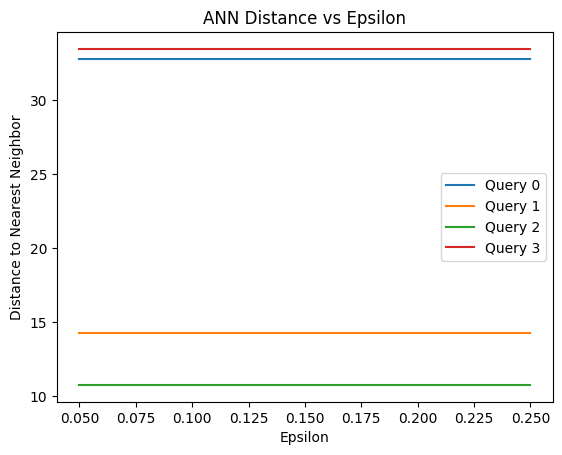

In [ ]:
import random
import matplotlib.pyplot as plt

class QuadTreeWithQuery(QuadTree):
    def nearest_neighbor(self, query, eps=0.1):
        best_point = None
        best_dist = float('inf')

        def search(node):
            nonlocal best_point, best_dist
            if not node.children:
                for point in node.points:
                    dist = np.linalg.norm(point - query)
                    if dist < best_dist:
                        best_dist = dist
                        best_point = point
                return

            for child in node.children:
                dist_to_region = np.max(np.abs(child.center - query) - (child.bounds[:, 1] - child.bounds[:, 0]) / 2)
                if dist_to_region <= (1 + eps) * best_dist:
                    search(child)

        search(self)
        return best_point


# Queries and Epsilon Variation
queries = [np.array([500, 500]), np.array([1000, 1000]), np.array([30, 950]), np.array([0, 1020])]
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]
results = []

# Rebuild quadtree for ANN
quadtree_ann = QuadTreeWithQuery(points, max_depth=15)

# Fixed Queries with Different Epsilons
for query in queries:
    distances = []
    for eps in epsilons:
        neighbor = quadtree_ann.nearest_neighbor(query, eps)
        distances.append(np.linalg.norm(query - neighbor))
    results.append(distances)

# Plot Results
for i, distances in enumerate(results):
    plt.plot(epsilons, distances, label=f"Query {i}")
plt.xlabel("Epsilon")
plt.ylabel("Distance to Nearest Neighbor")
plt.legend()
plt.title("ANN Distance vs Epsilon")
plt.show()

In [ ]:
# Random Queries in [0, 1000] × [0, 1000]
random_queries = [np.array([random.uniform(0, 1000), random.uniform(0, 1000)]) for _ in range(1000)]
query_times = []
distances = []

for query in random_queries:
    start_time = time.time()
    neighbor = quadtree_ann.nearest_neighbor(query, eps=0.1)
    query_times.append(time.time() - start_time)
    distances.append(np.linalg.norm(query - neighbor))

print(f"Average Query Time (0-1000): {np.mean(query_times):.6f} seconds")
print(f"Average Distance (0-1000): {np.mean(distances):.4f}")

Average Query Time (0-1000): 0.007921 seconds
Average Distance (0-1000): 13.5740


In [ ]:
# Random Queries in [1000, 1500] × [1000, 1500]
random_queries_far = [np.array([random.uniform(1000, 1500), random.uniform(1000, 1500)]) for _ in range(1000)]
query_times_far = []
distances_far = []

for query in random_queries_far:
    start_time = time.time()
    neighbor = quadtree_ann.nearest_neighbor(query, eps=0.1)
    query_times_far.append(time.time() - start_time)
    distances_far.append(np.linalg.norm(query - neighbor))

print(f"Average Query Time (1000-1500): {np.mean(query_times_far):.6f} seconds")
print(f"Average Distance (1000-1500): {np.mean(distances_far):.4f}")

Average Query Time (1000-1500): 0.037345 seconds
Average Distance (1000-1500): 13.5704


# **Part 3**

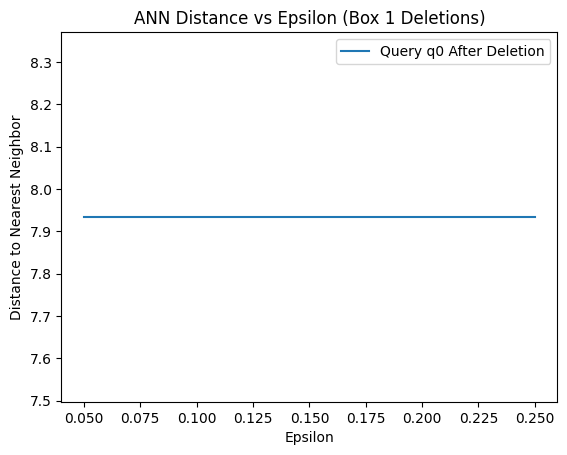

In [ ]:
import numpy as np
import time
import random
import matplotlib.pyplot as plt


class QuadTreeWithDeletion:
    def __init__(self, points, depth=0, max_depth=10):
        self.points = points
        self.children = []
        self.depth = depth
        self.center = np.mean(points, axis=0) if len(points) > 0 else None
        self.bounds = np.array([[np.min(points[:, i]), np.max(points[:, i])] for i in range(points.shape[1])]) if len(points) > 0 else None
        self.representative = points[0] if len(points) > 0 else None
        self.max_depth = max_depth
        self.active = len(points) > 0

        if depth < max_depth and len(points) > 1:
            self.subdivide()

    def subdivide(self):
        d = self.points.shape[1]
        midpoints = [(self.bounds[i, 0] + self.bounds[i, 1]) / 2 for i in range(d)]
        masks = self.get_masks(midpoints)

        for mask in masks:
            subset = self.points[np.all((self.points >= mask[0]) & (self.points < mask[1]), axis=1)]
            if len(subset) > 0:
                self.children.append(QuadTreeWithDeletion(subset, depth=self.depth + 1, max_depth=self.max_depth))

    def get_masks(self, midpoints):
        d = len(midpoints)
        masks = []
        for i in range(2**d):
            bits = bin(i)[2:].zfill(d)
            lower_bound = []
            upper_bound = []
            for j in range(d):
                if bits[j] == '0':
                    lower_bound.append(self.bounds[j, 0])
                    upper_bound.append(midpoints[j])
                else:
                    lower_bound.append(midpoints[j])
                    upper_bound.append(self.bounds[j, 1])
            masks.append((np.array(lower_bound), np.array(upper_bound)))
        return masks

    def find_leaf(self, point):
        """Find the leaf node containing the point."""
        if not self.children:
            return self
        for child in self.children:
            if np.all((point >= child.bounds[:, 0]) & (point < child.bounds[:, 1])):
                return child.find_leaf(point)
        return None

    def delete(self, point):
        """Delete a point from the quadtree."""
        leaf = self.find_leaf(point)
        if leaf and point in leaf.points:
            leaf.points = leaf.points[leaf.points != point].reshape(-1, point.shape[0])
            if len(leaf.points) == 0:
                leaf.active = False
                leaf.representative = None
            else:
                leaf.representative = leaf.points[0]

    def reconstruct(self, points):
        """Reconstruct the quadtree with new points."""
        return QuadTreeWithDeletion(points, max_depth=self.max_depth)

    def nearest_neighbor(self, query, eps=0.1):
        """Approximate nearest neighbor query."""
        best_point = None
        best_dist = float('inf')

        def search(node):
            nonlocal best_point, best_dist
            if not node.active:
                return
            if not node.children:
                for point in node.points:
                    dist = np.linalg.norm(point - query)
                    if dist < best_dist:
                        best_dist = dist
                        best_point = point
                return
            for child in node.children:
                dist_to_region = np.max(np.abs(child.center - query) - (child.bounds[:, 1] - child.bounds[:, 0]) / 2)
                if dist_to_region <= (1 + eps) * best_dist:
                    search(child)

        search(self)
        return best_point


# Generate synthetic dataset
def generate_points(num_points, dimension, bounds):
    return np.random.uniform(bounds[0], bounds[1], size=(num_points, dimension))


# Experiment setup
points = generate_points(10000, 2, [0, 2000])
quadtree = QuadTreeWithDeletion(points, max_depth=15)

# Deletions in [450, 550] × [450, 550]
box1 = [450, 550]
to_delete_box1 = points[(points[:, 0] >= box1[0]) & (points[:, 0] <= box1[1]) &
                        (points[:, 1] >= box1[0]) & (points[:, 1] <= box1[1])]

start_time = time.time()
for point in to_delete_box1:
    quadtree.delete(point)
average_deletion_time_box1 = (time.time() - start_time) / len(to_delete_box1)

# ANN query q0 = (500, 500) after deletions
query_q0 = np.array([500, 500])
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]
distances_box1 = []

for eps in epsilons:
    neighbor = quadtree.nearest_neighbor(query_q0, eps)
    distances_box1.append(np.linalg.norm(query_q0 - neighbor))

# Plot results for box 1
plt.plot(epsilons, distances_box1, label="Query q0 After Deletion")
plt.xlabel("Epsilon")
plt.ylabel("Distance to Nearest Neighbor")
plt.title("ANN Distance vs Epsilon (Box 1 Deletions)")
plt.legend()
plt.show()

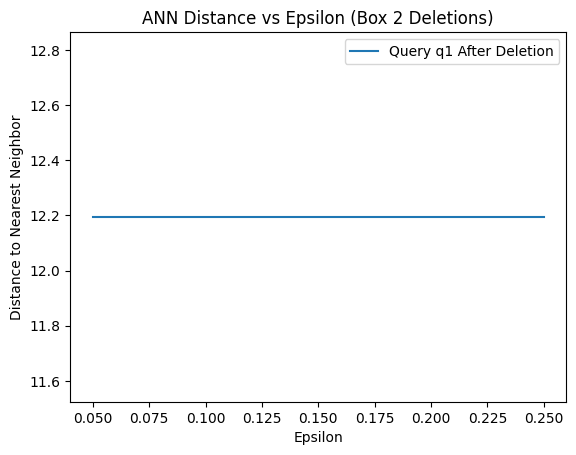

In [ ]:
# Deletions in [900, 1000] × [900, 1000]
box2 = [900, 1000]
to_delete_box2 = points[(points[:, 0] >= box2[0]) & (points[:, 0] <= box2[1]) &
                        (points[:, 1] >= box2[0]) & (points[:, 1] <= box2[1])]

start_time = time.time()
for point in to_delete_box2:
    quadtree.delete(point)
average_deletion_time_box2 = (time.time() - start_time) / len(to_delete_box2)

# ANN query q1 = (1000, 1000) after deletions
query_q1 = np.array([1000, 1000])
distances_box2 = []

for eps in epsilons:
    neighbor = quadtree.nearest_neighbor(query_q1, eps)
    distances_box2.append(np.linalg.norm(query_q1 - neighbor))

# Plot results for box 2
plt.plot(epsilons, distances_box2, label="Query q1 After Deletion")
plt.xlabel("Epsilon")
plt.ylabel("Distance to Nearest Neighbor")
plt.title("ANN Distance vs Epsilon (Box 2 Deletions)")
plt.legend()
plt.show()

In [ ]:
# Reconstruct tree and delete 1000 points
remaining_points = points[points[:, 0] > 1000]  # Use any condition to select remaining points
quadtree = quadtree.reconstruct(remaining_points)
to_delete_more = remaining_points[:1000]

start_time = time.time()
for point in to_delete_more:
    quadtree.delete(point)
average_deletion_time_more = (time.time() - start_time) / len(to_delete_more)

# Remaining points in the tree
remaining_count = sum(len(node.points) for node in [quadtree])

# Final Results
print(f"Average Deletion Time Box 1: {average_deletion_time_box1:.6f}")
print(f"Average Deletion Time Box 2: {average_deletion_time_box2:.6f}")
print(f"Average Deletion Time After Reconstruction: {average_deletion_time_more:.6f}")
print(f"Remaining Points in Tree: {remaining_count}")


Average Deletion Time Box 1: 0.000172
Average Deletion Time Box 2: 0.000185
Average Deletion Time After Reconstruction: 0.000189
Remaining Points in Tree: 4936


# **Part 4**

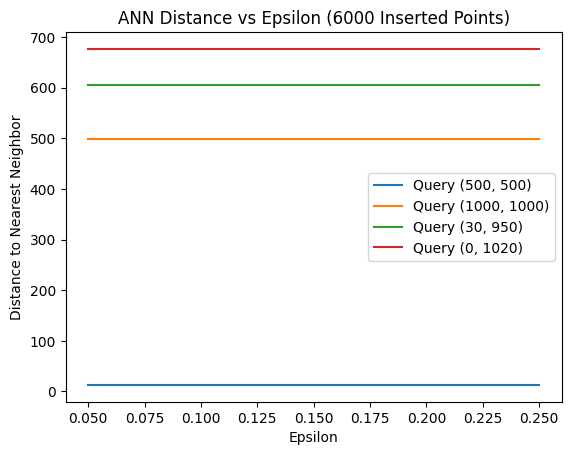

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt


class QuadTreeWithInsertion:
    def __init__(self, points=None, bounds=None, depth=0, max_depth=10):
        self.points = points if points is not None else []
        self.children = []
        self.depth = depth
        self.bounds = bounds
        self.representative = points[0] if points else None
        self.max_depth = max_depth

    def insert(self, point):
        """Insert a point into the quadtree."""
        if self.bounds is None:
            self.bounds = np.array([[point[i], point[i]] for i in range(len(point))])
        else:
            self.bounds[:, 0] = np.minimum(self.bounds[:, 0], point)
            self.bounds[:, 1] = np.maximum(self.bounds[:, 1], point)

        if self.depth < self.max_depth and len(self.points) >= 4:
            if not self.children:
                self.subdivide()
            for child in self.children:
                if self.point_in_bounds(point, child.bounds):
                    child.insert(point)
                    return

        self.points.append(point)
        self.representative = self.points[0]

    def subdivide(self):
        """Subdivide the quadtree into child nodes."""
        d = len(self.bounds)
        midpoints = [(self.bounds[i, 0] + self.bounds[i, 1]) / 2 for i in range(d)]
        self.children = [QuadTreeWithInsertion(bounds=self.get_child_bounds(midpoints, mask), depth=self.depth + 1, max_depth=self.max_depth)
                         for mask in range(2 ** d)]

        # Move points to appropriate children
        for point in self.points:
            for child in self.children:
                if self.point_in_bounds(point, child.bounds):
                    child.insert(point)
                    break
        self.points = []

    def get_child_bounds(self, midpoints, mask):
        d = len(midpoints)
        bounds = []
        for i in range(d):
            if (mask >> i) & 1 == 0:
                bounds.append([self.bounds[i, 0], midpoints[i]])
            else:
                bounds.append([midpoints[i], self.bounds[i, 1]])
        return np.array(bounds)

    @staticmethod
    def point_in_bounds(point, bounds):
        return np.all((point >= bounds[:, 0]) & (point < bounds[:, 1]))

    def nearest_neighbor(self, query, eps=0.1):
        """Approximate nearest neighbor query."""
        best_point = None
        best_dist = float('inf')

        def search(node):
            nonlocal best_point, best_dist
            if node.children:
                for child in node.children:
                    dist_to_region = np.max(np.abs(child.bounds.mean(axis=1) - query) -
                                            (child.bounds[:, 1] - child.bounds[:, 0]) / 2)
                    if dist_to_region <= (1 + eps) * best_dist:
                        search(child)
            else:
                for point in node.points:
                    dist = np.linalg.norm(point - query)
                    if dist < best_dist:
                        best_dist = dist
                        best_point = point

        search(self)
        return best_point


# Generate synthetic dataset
def generate_points(num_points, bounds):
    """Generate random points within given bounds."""
    dimension = len(bounds) // 2
    return np.random.uniform(bounds[:dimension], bounds[dimension:], size=(num_points, dimension))


# Experiment setup
quadtree = QuadTreeWithInsertion(max_depth=15)

# Insert 6000 random points into [0, 1000] × [0, 1000]
points_6000 = generate_points(6000, [0, 0, 1000, 1000])
for point in points_6000:
    quadtree.insert(point)

# Queries and analysis
queries = [np.array([500, 500]), np.array([1000, 1000]), np.array([30, 950]), np.array([0, 1020])]
epsilons = [0.05, 0.1, 0.15, 0.2, 0.25]

results = {}
for query in queries:
    distances = []
    for eps in epsilons:
        neighbor = quadtree.nearest_neighbor(query, eps)
        distances.append(np.linalg.norm(query - neighbor))
    results[tuple(query)] = distances

# Plot results
for query, distances in results.items():
    plt.plot(epsilons, distances, label=f"Query {query}")
plt.xlabel("Epsilon")
plt.ylabel("Distance to Nearest Neighbor")
plt.title("ANN Distance vs Epsilon (6000 Inserted Points)")
plt.legend()
plt.show()

In [ ]:
# Random queries in [0, 1000] × [0, 1000]
random_queries = generate_points(1000, [0, 0, 1000, 1000])
start_time = time.time()
distances = [np.linalg.norm(query - quadtree.nearest_neighbor(query, eps=0.1)) for query in random_queries]
average_time = (time.time() - start_time) / len(random_queries)
average_distance = np.mean(distances)

print(f"Random Queries in [0, 1000] x [0, 1000]: Avg Query Time = {average_time:.6f}, Avg Distance = {average_distance:.6f}")

Random Queries in [0, 1000] x [0, 1000]: Avg Query Time = 0.009418, Avg Distance = 194.804266


In [ ]:
# Insert 2000 random points into [1000, 2000] × [1000, 2000]
points_2000 = generate_points(2000, [1000, 1000, 2000, 2000])
for point in points_2000:
    quadtree.insert(point)

# Random queries in [1000, 2000] × [1000, 2000]
random_queries_2 = generate_points(1000, [1000, 1000, 2000, 2000])
start_time = time.time()
distances_2 = [np.linalg.norm(query - quadtree.nearest_neighbor(query, eps=0.1)) for query in random_queries_2]
average_time_2 = (time.time() - start_time) / len(random_queries_2)
average_distance_2 = np.mean(distances_2)

print(f"Random Queries in [1000, 2000] x [1000, 2000]: Avg Query Time = {average_time_2:.6f}, Avg Distance = {average_distance_2:.6f}")

Random Queries in [1000, 2000] x [1000, 2000]: Avg Query Time = 0.025011, Avg Distance = 1190.717901


In [ ]:
# Comparison
print(f"Comparison of Query Results:")
print(f"[0, 1000] x [0, 1000]: Avg Query Time = {average_time:.6f}, Avg Distance = {average_distance:.6f}")
print(f"[1000, 2000] x [1000, 2000]: Avg Query Time = {average_time_2:.6f}, Avg Distance = {average_distance_2:.6f}")

Comparison of Query Results:
[0, 1000] x [0, 1000]: Avg Query Time = 0.009418, Avg Distance = 194.804266
[1000, 2000] x [1000, 2000]: Avg Query Time = 0.025011, Avg Distance = 1190.717901
